<a href="https://colab.research.google.com/github/CobaMasa/PythonMachineLearningProgramming/blob/master/chapter3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparing

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.datasets import load_iris

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
## Improving plot decision regions
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100,
                    label='test test')

In [3]:
# HORIZONTAL BATTLE: ndarray.ravel() vs np.hstack()  vs ndarray.reshape
import time

n = 1000
ones = np.ones(n**2).reshape(n, n)
floats = np.random.normal(size=n**2).reshape(n, n)

# Entry1: ravel
s11 = time.time()
ones.ravel()
e11 = time.time()
s12 = time.time()
floats.ravel()
e12 = time.time()

# Entry2: hstack
s21 = time.time()
np.hstack(ones)
e21 = time.time()
s22 = time.time()
np.hstack(floats)
e22 = time.time()

# Entry3: reshape
s31 = time.time()
ones.reshape(1, -1)
e31 = time.time()
s32 = time.time()
floats.reshape(1, -1)
e32 = time.time()

print('-ravel: \n', e11-s11, '\n', e12-s12)
print('-hstack: \n', e21-s21, '\n', e22-s22)
print('-reshape: \n', e31-s31, '\n', e32-s32)

-ravel: 
 4.124641418457031e-05 
 2.7418136596679688e-05
-hstack: 
 0.004421234130859375 
 0.002378702163696289
-reshape: 
 5.698204040527344e-05 
 2.9325485229492188e-05


In [4]:
## a bit unfamilier expression to me
ones = np.ones(10)
twos = np.ones(25)*2
fives = np.ones(15) * 5

## how to make horizontal vactors
y = np.concatenate([ones, twos, fives]).astype(np.int8)
print(np.hstack(y).shape)
print(y.ravel().shape)

## trying np.bincount()
np.random.shuffle(y)
np.bincount(y)

(50,)
(50,)


array([ 0, 10, 25,  0,  0, 15])

## Logistic Regression

In [5]:
## warming-up
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

iris = load_iris()
X = iris.data[:, [2, 3]]
X_std = ss.fit_transform(X)
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.3, stratify=y)

print('bincounts: ', np.bincount(y_train))

bincounts:  [35 35 35]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


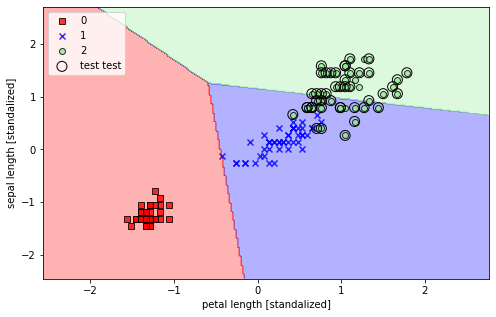

In [6]:
ppn = Perceptron(max_iter=40, alpha=0.001).fit(X_std, y)

fig = plt.figure(figsize=(8, 5))
plot_decision_regions(X_std, y, classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standalized]')
plt.ylabel('sepal length [standalized]')
plt.legend(loc='upper left')
plt.show();

### Motivation
Wanna answer the question, "Which group label shold we return as an output with (these) feature values?", including **the probability** to which groups the data seems to belong.

---
Considering input effect as 
$$
    z = \sum_{i=0}^m w_ix_i \ \ (x_0=1)
$$
we wanna get some **probabilities** from this somehow.
Then we use kinda translater
$$
    \phi(z) = \frac{1}{1+e^{-z}}
$$
This function restrict the range of $z \ (-\infty<z<\infty)$ into $0<\phi(z)<1$.
We call this function $\phi(\cdot)$, **Logistic** function, (or sigmoid function).

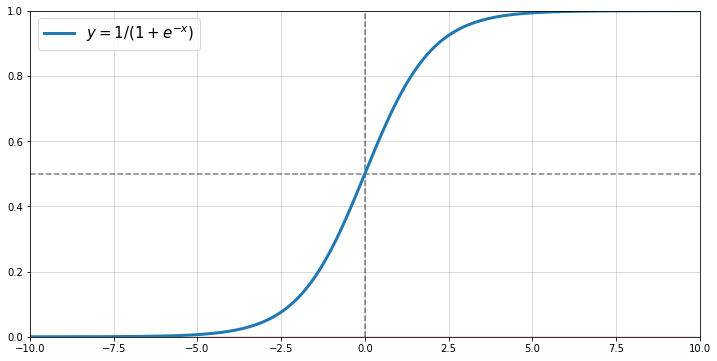

In [7]:
#plotting sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def logit(x):
    return np.log(x/(1-x))


fig, ax = plt.subplots(1, 1, figsize=(12, 6)) # Trying to compare sigmoid to odds at first, kinda waste of time
x = np.linspace(-10, 10, 200)
plt.plot(x, sigmoid(x), lw=3, label='$y=1/(1+e^{-x})$')
# plt.plot(x, logit(x), lw=3, label='$y=\log(x/(1-x))$')

plt.vlines(0, 0, 1, ls='--', alpha=0.5)
plt.hlines(0.5, -10, 10, ls='--', alpha=0.5)
plt.hlines(0, -10, 10, alpha=0.3, color='indianred')
plt.hlines(1, -10, 10, alpha=0.3, color='indianred')
plt.grid(alpha=0.6)

plt.xlim(-10, 10)
plt.ylim(0, 1)
plt.legend(loc='upper left', fontsize=15, ncol=1)
plt.show();

ACC: 0.977778
Return probs: 
 [[9.990e-01 9.506e-04 7.550e-16]
 [9.997e-01 2.829e-04 8.864e-17]
 [9.994e-01 6.049e-04 3.936e-16]]


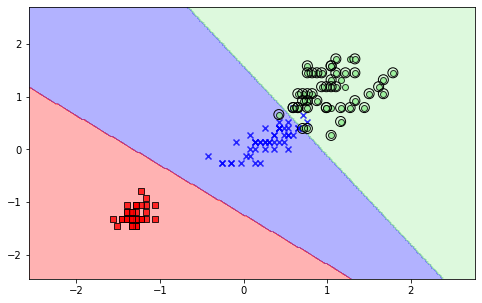

In [8]:
## modeling & precdiction
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(precision=3)

lr = LogisticRegression(C=100.0)

lr.fit(X_train, y_train)
print('ACC: {:.6f}'.format(lr.score(X_test, y_test)))
print('Return probs: \n', lr.predict_proba(X_test[:3]))

fig = plt.figure(figsize=(8, 5))
plot_decision_regions(X_std, y, classifier=lr, test_idx=range(105, 150))
plt.show();